Code for examining how HMM performs under different perturbations to population activity. 

Tests recalibration performance in response to mean shifts, PD shifts

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from HMM_matlab import hmmviterbi_vonmises, hmmdecode_vonmises
from hmm_utils import *
from simulation_matlab import *
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [46]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)

calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.8      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


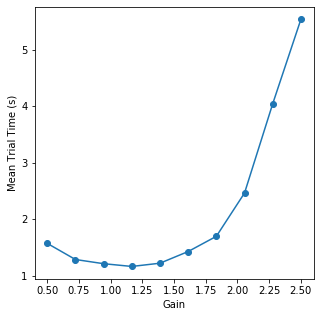

In [47]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [48]:
# general settings:

nSimSteps    = 100000
n_sessions   = 5
days_between = 0


posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)

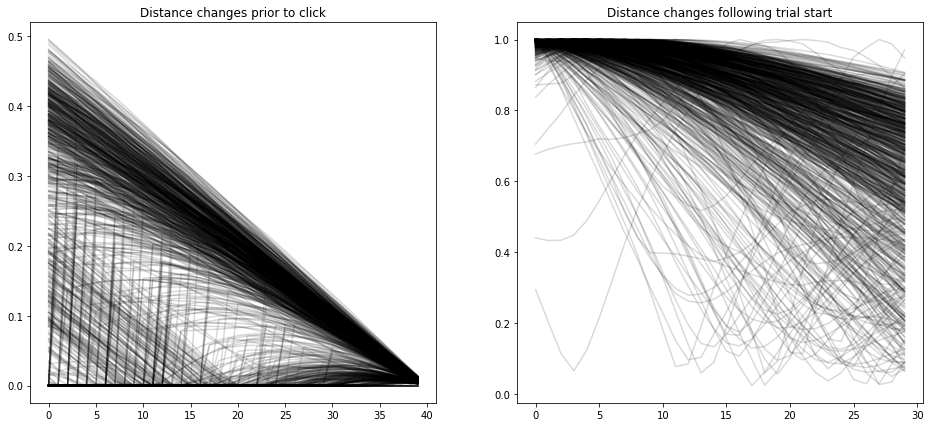

In [49]:
figSize(7, 16)

lookback   = 40
nHoldSteps = 50

plt.subplot(1, 2, 1)
plt.title('Distance changes prior to click')
for t in np.concatenate(trialStart - 1).astype('int'):
    dist  = np.linalg.norm(posTraj[(t - nHoldSteps - lookback):(t - nHoldSteps), :] - targTraj[(t - nHoldSteps - lookback):(t - nHoldSteps), :], axis = 1)
    dist  = np.maximum(dist - 0.0725, 0)
    plt.plot(dist, color = 'k', alpha = 0.15)
    
    
plt.subplot(1, 2, 2)
plt.title('Distance changes following trial start')
for i, t in enumerate(np.concatenate(trialStart).astype('int')[:-2]):
    dist  = np.linalg.norm(posTraj[t:(t + 30), :] - targTraj[t:(t + 30), :], axis = 1)
    dist /= dist.max()
    plt.plot(dist, color = 'k', alpha = 0.15)

R2:  0.32130891263600586
SNR:  1.5763147282560295


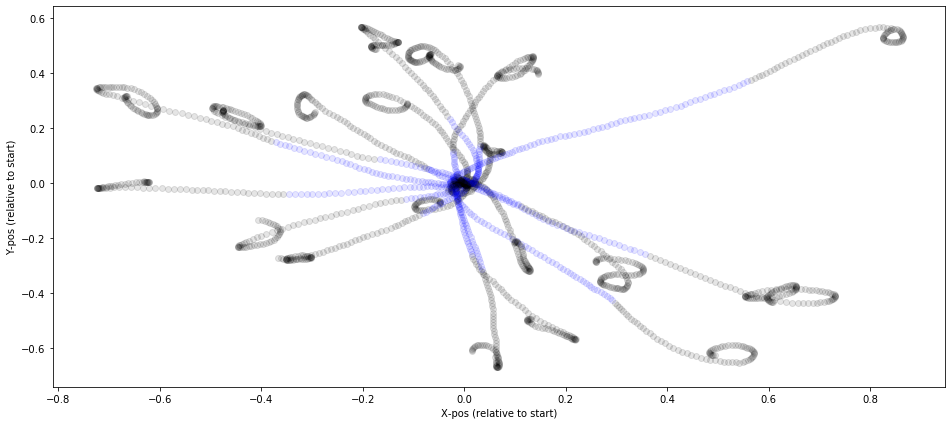

In [50]:
thresh          = 0.3   # only calculate SNR using points far from target
cutStart        = 7     # exclude first <cutStart> timesteps

#for i in range(len(trialStart) - 1):
for i in range(20):
    start = int(trialStart[i] - 1)
    stop  = int(trialStart[i+1] - 2)
    
    trlTraj          = posTraj[start:stop, :] 
    trlTraj_centered = trlTraj - posTraj[start, :]
    trlTarg          = targTraj[start:stop, :]
    
    dists     = np.linalg.norm(trlTraj - targTraj[start, :], axis = 1)
    too_close = np.where(dists < thresh)[0]
    unused    = np.concatenate([np.arange(cutStart), too_close])
    used      = np.setdiff1d(np.arange(len(dists)),unused)

    _ = plt.scatter(trlTraj_centered[used, 0], trlTraj_centered[used, 1], color = 'b', alpha = 0.1)
    _ = plt.scatter(trlTraj_centered[unused, 0], trlTraj_centered[unused, 1], color = 'k', alpha = 0.1)
    
plt.xlabel('X-pos (relative to start)')
plt.ylabel('Y-pos (relative to start)')

# Now calculate R^2 and SNR estimate for these subselected timepoints: 
cursorErr = targTraj - posTraj
dists     = np.linalg.norm(cursorErr, axis = 1)
lm        = LinearRegression().fit(neuralTraj, cursorErr)
print('R2: ', lm.score(neuralTraj[dists > thresh, :], cursorErr[dists > thresh, :]))

p_t       = cursorErr / dists[:, np.newaxis]  # unit vector pointing at target
u_t       = lm.predict(neuralTraj)  
ut_thresh = u_t[dists > thresh, :].flatten()[:, np.newaxis]
pt_thresh =  p_t[dists > thresh, :].flatten()[:, np.newaxis]

mult  = np.linalg.lstsq(pt_thresh, ut_thresh, rcond = None)[0][0][0]
res   = ut_thresh - (pt_thresh * mult)

print('SNR: ', mult / np.std(res))

In [120]:
# general settings:
nSimSteps     = 100000
n_repeats     = 10
tuning_shift  = [0.92, 1, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
renormalize   = True
max_stretch   = 14   # simulate n_repeats random chains of nonstationarities out this many days

#-----------------------------------------
session_scores  = np.zeros((max_stretch, n_repeats,)) 
distortion_mats = np.zeros((max_stretch, n_repeats, 2, 2)) 
 

# send parameters over to matlab for fast parallelized code:
eng     = matlab.engine.start_matlab()
tuning  = [initialTuning for j in range(n_repeats)]

for i in range(max_stretch):
    tuning          = [simulateTuningShift(tuning[j], PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], mean_shift = tuning_shift[2], renormalize = renormalize) for j in range(n_repeats)]
    distmats, ttt   = generateDistortionMatrices_parallel(tuning, np.copy(D), alpha, beta, nDelaySteps, delT, nSimSteps, engine = eng)
    print(np.linalg.norm(tuning[0], axis = 0))
    session_scores[i, :]      = np.asarray([np.mean(times) for times in ttt])
    distortion_mats[i, :,:,:] = np.stack(distmats)

    print('Day ', i + 1, ' finished.')

eng.quit()

diffs           = np.concatenate([i * np.ones((n_repeats)) for i in range(1, max_stretch + 1)])
distortion_mats = distortion_mats.reshape(n_repeats*max_stretch, 2, 2)

[13.91209037  0.51335442  0.50341805]
Day  1  finished.
[13.91209037  0.52161424  0.49646406]
Day  2  finished.
[13.91209037  0.53467722  0.50585027]
Day  3  finished.
[13.91209037  0.54060249  0.50313714]
Day  4  finished.
[13.91209037  0.53250395  0.51856425]
Day  5  finished.
[13.91209037  0.53499748  0.51913164]
Day  6  finished.
[13.91209037  0.54146447  0.51910898]
Day  7  finished.
[13.91209037  0.54863324  0.51343401]
Day  8  finished.
[13.91209037  0.54121429  0.54253875]
Day  9  finished.
[13.91209037  0.56126915  0.54670371]
Day  10  finished.
[13.91209037  0.56188556  0.55925119]
Day  11  finished.
[13.91209037  0.57872082  0.56170258]
Day  12  finished.
[13.91209037  0.5820288   0.5753085 ]
Day  13  finished.
[13.91209037  0.5873214   0.55447362]
Day  14  finished.


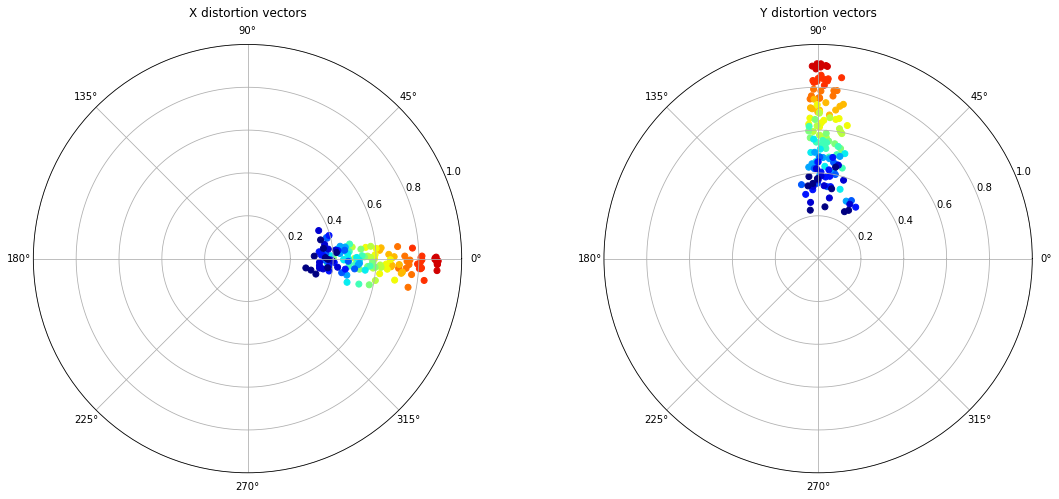

In [121]:
import matplotlib.cm as cm

labels = ['X distortion vectors', 'Y distortion vectors']

for i, lab in enumerate(labels):
    plt.subplot(1, 2, i + 1, projection='polar')
    
    theta = np.arctan2(distortion_mats[:, 1, i], distortion_mats[:, 0, i])
    r     = np.linalg.norm(distortion_mats[:, :, i], axis = 1)
    plt.scatter(theta, r, color = cm.jet(1 - (diffs / max(diffs))))
    ax = plt.gca()
    ax.set_rlim([0, 1])
    
    plt.title(lab)
    
plt.tight_layout()

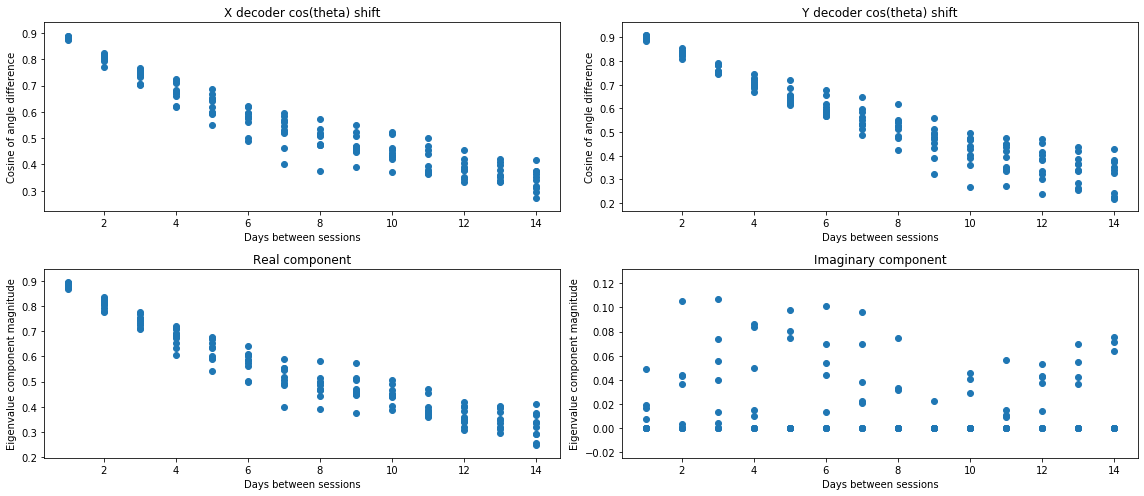

In [122]:
labels = ['X decoder cos(theta) shift', 'Y decoder cos(theta) shift']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.scatter(diffs, distortion_mats[:, i, i])
    plt.title(label)
    plt.xlabel('Days between sessions')
    plt.ylabel('Cosine of angle difference')
    

eigvals     = [np.linalg.eigvals(distortion_mats[i, :, :])[0] for i in range(len(diffs))]
eigval_comp = [np.real(eigvals), np.imag(eigvals)]

labels = ['Real component', 'Imaginary component']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 3)
    plt.scatter(diffs, eigval_comp[i])
    plt.title(label)
    plt.xlabel('Days between sessions')
    plt.ylabel('Eigenvalue component magnitude')
    
plt.tight_layout()